# Implementinf a vanilla MAML on MNIST data set 
- this is the FOMAML


In [1]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

In [2]:
# -- Hyper parameters --
n_way = 5 # the total number of classes in which i want to classify
k_shot = 1 # the total number of support examples per class
q_queries = 16 # the total number of query examples per class
inner_lr = 0.02 # the learning rate for the inner loop (task specific adaptation)
meta_lr = 0.001 # learning rate for the outer loop (meta-optimisation)
meta_batch_size = 32 # number of tasks per meta-batch
training_step = 1000 # number of meta updates to perform
inner_steps = 5 # the number of gradient steps

# -- Device Setup --
device = torch.device("mps")
print(f'Using device:{device}')

Using device:mps


In [5]:
# -- Data Loading --
# Seperate the dataset per class so that sampling becomes easier
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_train = datasets.MNIST('data', train=True, transform=transform, download=True)
# Grouping the data by labels
train_data_byclass = {i:[] for i in range(10)}
for x,y in mnist_train:
    train_data_byclass[y].append(x)
for i in range(10):
    # stack the list of image into a single tensor for each class
    train_data_byclass[i] = torch.stack(train_data_byclass[i])

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 140kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 368kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.98MB/s]


In [6]:
# -- Task Sampling --
''' One of the most important step. We need a function that can
sample a batch from the dataset where each has S, Q'''
def sample_task_batch(data_by_class, batch_size, n_way, k_shot, q_queries):
    support_x_batch, support_y_batch = [], []
    query_x_batch, query_y_batch = [], []
    for _ in range(batch_size):
        # 1. Select the N classes for the task
        selected_class = np.random.choice(10, n_way, replace=False)
        support_x, support_y = [], []
        query_x, query_y = [], []
        for i, idx in enumerate(data_by_class):
            # 2. sample K-shot support and q_queries for each class
            class_data = data_by_class[idx]
            num_samples= class_data.shape[0] # checks how many samples are there in the specific class i

            if num_samples<k_shot+q_queries:
                raise ValueError(f"Not enough samples for class {idx}")
            # sample the indices without replacement
            shuffled_indices = torch.randperm(num_samples)
            support_indices = shuffled_indices[:k_shot]
            query_indices = shuffled_indices[k_shot:k_shot+q_queries]
            support_x.append(class_data[support_indices])
            # for the samples for k_shot samples, create a tensor of size=kshot, fill value = class (here it becomes 'i')
            support_y.append(torch.full((k_shot,), i, dtype=torch.long))
            query_x.append(class_data[query_indices])
            query_y.append(torch.full((q_queries,), i, dtype=torch.long))

        # append to the batch
        support_x_batch.append(torch.cat(support_x))
        support_y_batch.append(torch.cat(support_y))
        query_x_batch.append(torch.cat(query_x))
        query_y_batch.append(torch.cat(query_y))
    # stack the list of tensor to create a single batch tensor
    return (torch.stack(support_x_batch), torch.stack(support_y_batch),
            torch.stack(query_x_batch), torch.stack(query_y_batch))

In [7]:
# -- Base learner Model: A CNN --
class CNN(nn.Module):
    def __init__(self, in_channel=1, n_way=5):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.classifier = nn.Linear(64*7*7, n_way)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [8]:
meta_model = CNN(in_channel=1, n_way=5).to(device)
meta_optimizer = optim.Adam(meta_model.parameters(), lr= meta_lr)

In [9]:
meta_model.parameters

<bound method Module.parameters of CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=3136, out_features=5, bias=True)
)>

## The following is the first order approximation for the maml code
- Even in the original paper the authors have stated that the use of FOMAML gave close to similar results to MAML 
- The reason they specified was with a second order derivative - it seemed like a lot of gradients were being reduced to zero also adding to the vanishing gradients
- and when compared against the FOMAML, the revelation was that the post-updated weight gradients had the most contribution to selection of good initialization rather than the gradient of the gradient
- and the backpropogation is done on the pre-updated weights

In [30]:
print("Starting the FOMAML Training...")
# -- Outer Loop: Meta- training --
for step in range(training_step):
    # 1. Sample a batch of tasks
    support_x, support_y, query_x, query_y = sample_task_batch(train_data_byclass, batch_size=meta_batch_size, n_way=n_way, k_shot=k_shot, q_queries=q_queries)
    meta_optimizer.zero_grad()
    total_meta_ls = 0.0
    # -- Inner Loop --
    for i in range(meta_batch_size):
        # We create a temp model which thus breaks the main compuation graph
        fast_model = copy.deepcopy(meta_model)
        fast_optim = optim.SGD(fast_model.parameters(), lr = inner_lr)
        # For each task
        sx, sy = support_x[i].to(device), support_y[i].to(device)
        qx, qy = query_x[i].to(device), query_y[i].to(device)
        # 2. Ineer loop: train the fast_model on support set
        for _ in range(inner_steps):
            fast_optim.zero_grad()
            logits = fast_model(sx)
            loss = F.cross_entropy(logits, sy)
            loss.backward()
            fast_optim.step()
        # Calculate the meta loss on the query using fast_model
        query_logits = fast_model(qx)
        task_meta_loss = F.cross_entropy(query_logits, qy)
        total_meta_ls+= task_meta_loss
    # 4. Outer loop update: we change the meta model weights
    average_meta_ls = total_meta_ls/ meta_batch_size
    # Propogate the gradients from meta-loss to the original meta model
    average_meta_ls.backward()
    meta_optimizer.step()
    if (step + 1) % 100 ==0:
        print(f"Step {step+1}/{training_step}, Meta Loss: {average_meta_ls.item():.4f}")
print("FOMAML training done")


Starting the FOMAML Training...


KeyboardInterrupt: 

In [10]:
from tqdm.notebook import trange
import time

print("Starting the FOMAML Training...")
for step in trange(training_step, desc="Meta-training steps"):
    start_time = time.time()
    support_x, support_y, query_x, query_y = sample_task_batch(
        train_data_byclass, batch_size=meta_batch_size, n_way=n_way, k_shot=k_shot, q_queries=q_queries)
    meta_optimizer.zero_grad()
    total_meta_ls = 0.0
    for i in range(meta_batch_size):
        fast_model = copy.deepcopy(meta_model).to(device)
        fast_optim = optim.SGD(fast_model.parameters(), lr=inner_lr)
        sx, sy = support_x[i].to(device), support_y[i].to(device)
        qx, qy = query_x[i].to(device), query_y[i].to(device)
        for _ in range(inner_steps):
            fast_optim.zero_grad()
            logits = fast_model(sx)
            loss = F.cross_entropy(logits, sy)
            loss.backward()
            fast_optim.step()
        query_logits = fast_model(qx)
        task_meta_loss = F.cross_entropy(query_logits, qy)
        total_meta_ls += task_meta_loss
    average_meta_ls = total_meta_ls / meta_batch_size
    average_meta_ls.backward()
    meta_optimizer.step()
    if (step + 1) % 1 == 0:
        elapsed = time.time() - start_time
        print(f"Step {step+1}/{training_step}, Meta Loss: {average_meta_ls.item():.4f}, Time: {elapsed:.2f}s")
print("FOMAML training done")

Starting the FOMAML Training...


Meta-training steps:   0%|          | 0/1000 [00:00<?, ?it/s]

Step 1/1000, Meta Loss: 0.5109, Time: 1.70s
Step 2/1000, Meta Loss: 0.5432, Time: 0.73s
Step 3/1000, Meta Loss: 0.4943, Time: 0.65s
Step 4/1000, Meta Loss: 0.5444, Time: 0.60s
Step 5/1000, Meta Loss: 0.4903, Time: 0.58s
Step 6/1000, Meta Loss: 0.5445, Time: 0.58s
Step 7/1000, Meta Loss: 0.5277, Time: 0.58s
Step 8/1000, Meta Loss: 0.5163, Time: 0.60s
Step 9/1000, Meta Loss: 0.5079, Time: 0.59s
Step 10/1000, Meta Loss: 0.5033, Time: 0.59s
Step 11/1000, Meta Loss: 0.5219, Time: 0.57s
Step 12/1000, Meta Loss: 0.5247, Time: 0.57s
Step 13/1000, Meta Loss: 0.5310, Time: 0.63s
Step 14/1000, Meta Loss: 0.5641, Time: 0.59s
Step 15/1000, Meta Loss: 0.5304, Time: 0.58s
Step 16/1000, Meta Loss: 0.5284, Time: 0.57s
Step 17/1000, Meta Loss: 0.5095, Time: 0.56s
Step 18/1000, Meta Loss: 0.5105, Time: 0.68s
Step 19/1000, Meta Loss: 0.5271, Time: 0.59s
Step 20/1000, Meta Loss: 0.5039, Time: 0.69s
Step 21/1000, Meta Loss: 0.5569, Time: 0.63s
Step 22/1000, Meta Loss: 0.5360, Time: 0.61s
Step 23/1000, Meta 

Accuracy after 0 adaptation steps: 0.1287
Accuracy after 1 adaptation steps: 0.1761
Accuracy after 2 adaptation steps: 0.2442
Accuracy after 3 adaptation steps: 0.2995
Accuracy after 4 adaptation steps: 0.3519
Accuracy after 5 adaptation steps: 0.3856
Accuracy after 6 adaptation steps: 0.4021
Accuracy after 7 adaptation steps: 0.4121
Accuracy after 8 adaptation steps: 0.4176
Accuracy after 9 adaptation steps: 0.4217
Accuracy after 10 adaptation steps: 0.4249


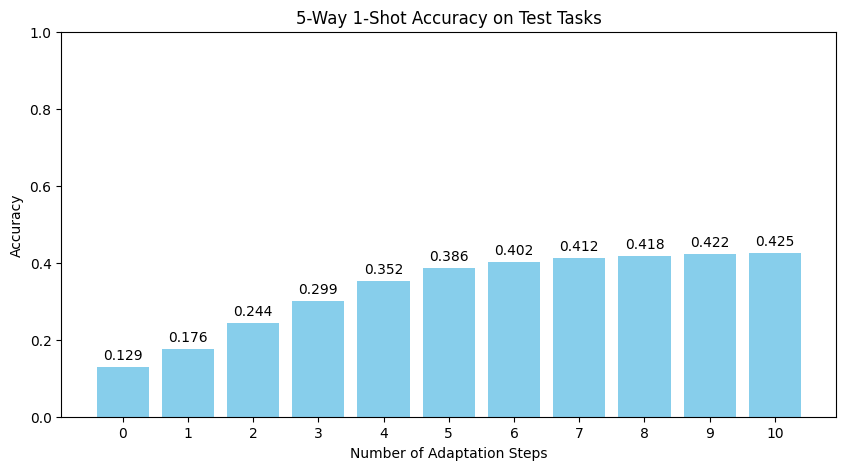

In [21]:
import matplotlib.pyplot as plt

def evaluate_maml(meta_model, data_by_class, n_tasks, n_way, k_shot, q_queries, inner_steps):
    """
    Evaluates the MAML model on a set of new tasks.
    """
    meta_model.eval() # Set the model to evaluation mode
    total_accuracies = [0.0] * (inner_steps + 1)

    for _ in range(n_tasks):
        # Sample a new task
        support_x, support_y, query_x, query_y = sample_task_batch(
            data_by_class, 1, n_way, k_shot, q_queries
        )
        # Remove the batch dimension of 1
        support_x, support_y = support_x[0].to(device), support_y[0].to(device)
        query_x, query_y = query_x[0].to(device), query_y[0].to(device)

        # 0. Evaluate before adaptation (0-shot)
        with torch.no_grad():
            query_logits = meta_model(query_x)
            preds = torch.argmax(query_logits, dim=1)
            accuracy = (preds == query_y).float().mean().item()
            total_accuracies[0] += accuracy

        # Create a fast model for adaptation
        fast_model = copy.deepcopy(meta_model)
        fast_optimizer = optim.SGD(fast_model.parameters(), lr=inner_lr)

        # 1. Adapt and evaluate for each inner step
        for step in range(inner_steps):
            # Adapt on support set
            fast_optimizer.zero_grad()
            logits = fast_model(support_x)
            loss = F.cross_entropy(logits, support_y)
            loss.backward()
            fast_optimizer.step()

            # Evaluate on query set
            with torch.no_grad():
                query_logits = fast_model(query_x)
                preds = torch.argmax(query_logits, dim=1)
                accuracy = (preds == query_y).float().mean().item()
                total_accuracies[step + 1] += accuracy

    # Calculate average accuracies
    avg_accuracies = [acc / n_tasks for acc in total_accuracies]
    return avg_accuracies

# --- Load Test Data ---
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transform)
test_data_by_class = {i: [] for i in range(10)}
for x, y in mnist_test:
    test_data_by_class[y].append(x)
for i in range(10):
    test_data_by_class[i] = torch.stack(test_data_by_class[i])

# --- Run Evaluation ---
N_EVAL_TASKS = 100
ADAPTATION_STEPS = 10
eval_accuracies = evaluate_maml(
    meta_model, test_data_by_class, N_EVAL_TASKS, n_way=5, k_shot=5, q_queries=16, inner_steps=10
)

for i, acc in enumerate(eval_accuracies):
    print(f"Accuracy after {i} adaptation steps: {acc:.4f}")

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.title(f"{n_way}-Way {k_shot}-Shot Accuracy on Test Tasks")
plt.xlabel("Number of Adaptation Steps")
plt.ylabel("Accuracy")
plt.bar(range(ADAPTATION_STEPS + 1), eval_accuracies, color='skyblue')
plt.xticks(range(ADAPTATION_STEPS + 1))
plt.ylim([0, 1])
for i, acc in enumerate(eval_accuracies):
    plt.text(i, acc + 0.02, f"{acc:.3f}", ha='center', color='black')
plt.show()

- This vanilla implementation of MAML on MNIST successfully demonstrates the core concept of `"learning to learn."` 
- The evaluation shows that the *model's accuracy consistently improves* with each inner-loop adaptation step on new, unseen tasks, proving that the meta-training process has found an initial set of weights that is amenable to fast fine-tuning. However, the final accuracy is only marginally better than random guessing. 
- This is not a limitation of the simple CNN architecture but rather **highlights that this is a conceptual proof-of-concept.** 
-Achieving high performance with MAML is notoriously sensitive to hyperparameters, particularly the inner and meta learning rates, and requires a significantly longer training regime to converge to a strong solution. 

The results here confirm the mechanism works, while underscoring that extensive training and tuning are necessary to move from a conceptual model to a powerful few-shot classifier.

## Actual MAML : with second order derivatives (calculated via Hessian vector products)

In [ ]:
# -- Outer Lopp: Meta- training --
for step in range(training_step):
    # we perform the sampling
    support_x, support_y, query_x, query_y = sample_task_batch(train_data_byclass, batch_size=meta_batch_size, n_way=n_way, k_shot=k_shot, q_queries=q_queries)
    total_meta_ls = 0.0
    meta_optimizer.zero_grad()

    # Process each task in the bact
    for i in range(meta_batch_size):
        sx, sy = support_x[i].to(device), support_y[i].to(device)
        qx, qy = query_x[i].to(device), query_y[i].to(device)

        # -- How actually we take the gradient thru a gradient
        # Start with the original meta-model weight for each tasks
        fast_weight = list(meta_model.parameters())

        # 1. Inner loop: task specific weight adaptations
        logits = F.conv2d(sx, fast_weight[0], fast_weight[1], stride=1, padding=1)
        logits = F.batch_norm(logits, running_mean=None, running_var=None, weight=fast_weight[2], bias=fast_weight[3], training=True)
        logits = F.relu(logits)
        logits = F.max_pool2d(logits, 2)
        logits = F.conv2d(logits, fast_weight[4], fast_weight[5], stride=1, padding=1)
        logits = F.batch_norm(logits, running_mean=None, running_var= None, weight=fast_weight[6], bias= fast_weight[7], training=True)
        logits = F.relu(logits)
        logits = F.max_pool2d(logits, 2)
        logits = logits.view(logits.size(0), -1)
        logits = F.linear(logits, fast_weight[8], fast_weight[9])

        loss = F.cross_entropy(logits, sy)
        # Calculate the gradients wrt fast_weight and store the graph (for 2nd order derivative)
        grad = torch.autograd.grad(loss, fast_weight, create_graph=True)
        # Weight update
        fast_weight = [w - inner_lr*g for w,g in zip(fast_weight, grad)]

    # 2. calculate the meta loss based on the query set
    # perform another full forward pass as above